In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms


class BoxDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Construct full image path
        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")

        # Convert one-hot encoding to a single label:
        if row[" EMPTY"] == 1:
            label = 0
        elif row[" FULL"] == 1:
            label = 1
        elif row[" PARTIAL"] == 1:
            label = 2
        else:
            raise ValueError("Invalid label in CSV")

        if self.transform:
            image = self.transform(image)

        return image, label


/home/rmateusc/miniconda3/envs/kiwibot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define transforms for training and validation
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Create dataset instances for training and validation
train_dataset = BoxDataset(
    csv_file="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/train/_classes.csv",
    img_dir="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/train",
    transform=train_transforms,
)
val_dataset = BoxDataset(
    csv_file="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/valid/_classes.csv",
    img_dir="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/valid",
    transform=val_transforms,
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [3]:

# Load a pretrained ResNet50 model
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to output 3 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Optionally, freeze feature extractor layers for initial training
for param in model.parameters():
    param.requires_grad = True  # Set False if you want to freeze layers


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/rmateusc/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 23.1MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    print(f"Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


torch.save(model.state_dict(), "model.pth")

Epoch 1/10 - Loss: 0.5556 Acc: 0.7637
Validation - Loss: 0.0893 Acc: 0.9880
Epoch 2/10 - Loss: 0.0518 Acc: 0.9932
Validation - Loss: 0.0158 Acc: 1.0000
Epoch 3/10 - Loss: 0.0143 Acc: 1.0000
Validation - Loss: 0.0153 Acc: 1.0000
Epoch 4/10 - Loss: 0.0140 Acc: 0.9966
Validation - Loss: 0.0073 Acc: 1.0000
Epoch 5/10 - Loss: 0.0151 Acc: 1.0000
Validation - Loss: 0.0622 Acc: 0.9759
Epoch 6/10 - Loss: 0.0350 Acc: 0.9897
Validation - Loss: 0.0073 Acc: 1.0000
Epoch 7/10 - Loss: 0.0285 Acc: 0.9932
Validation - Loss: 0.0153 Acc: 1.0000
Epoch 8/10 - Loss: 0.0118 Acc: 1.0000
Validation - Loss: 0.0074 Acc: 1.0000
Epoch 9/10 - Loss: 0.0105 Acc: 0.9966
Validation - Loss: 0.0045 Acc: 1.0000
Epoch 10/10 - Loss: 0.0097 Acc: 0.9966
Validation - Loss: 0.0038 Acc: 1.0000


In [5]:
# Create the test dataset instance using your CSV file and image directory
test_dataset = BoxDataset(csv_file='/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/test/_classes.csv',
                          img_dir='/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/test',
                          transform=val_transforms)

# Create the DataLoader for the test dataset.
# Batch size is often set to 1 for visualization purposes.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

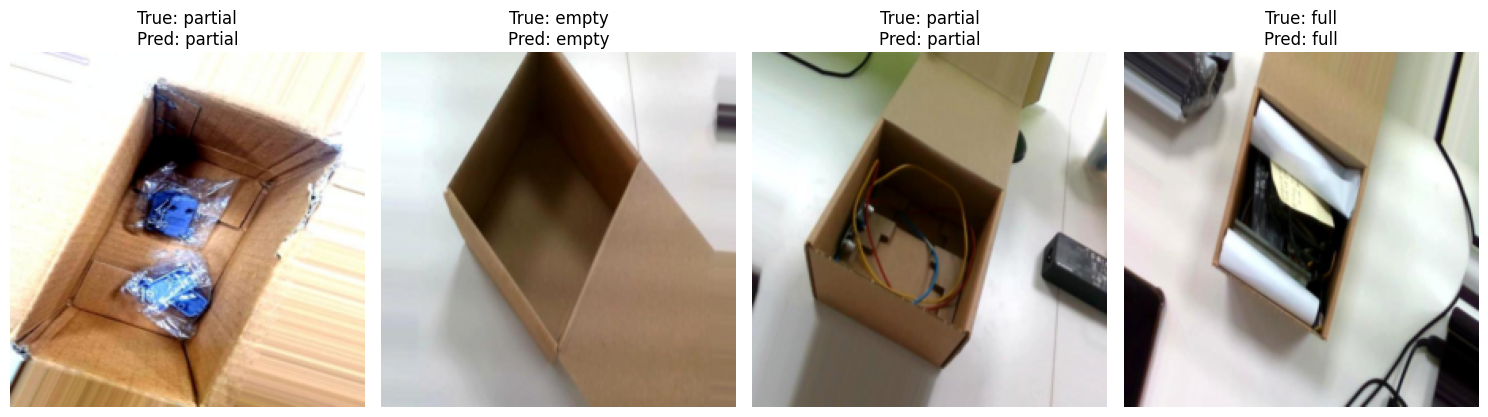

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Define a helper function to unnormalize and display an image.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Undo the normalization (assuming the following normalization in your transforms)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Mapping from integer label to class name. Adjust if your mapping is different.
class_names = {0: "empty", 1: "full", 2: "partial"}

# Assume you have already defined your test_dataset and test_loader similarly as:
# test_dataset = BoxDataset(csv_file='path/to/test_labels.csv', img_dir='path/to/images/', transform=val_transforms)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

# Set the model to evaluation mode and move it to the correct device.
model.eval()  # disable dropout, etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Number of images to display
num_images_to_plot = 4

# Create a figure for plotting.
plt.figure(figsize=(15, 4))

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        if i >= num_images_to_plot:
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get model predictions.
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Move the input back to CPU for visualization.
        img = inputs.cpu().squeeze(0)  # Remove the batch dimension.
        
        # Prepare title with true and predicted labels.
        true_label = class_names[labels.item()]
        pred_label = class_names[preds.item()]
        title = f"True: {true_label}\nPred: {pred_label}"
        
        # Plot the image.
        plt.subplot(1, num_images_to_plot, i + 1)
        imshow(img, title=title)

plt.tight_layout()
plt.show()


In [7]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Ensure the model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to collect all true labels and predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Generate classification report
# Ensure that the target names match your class mapping
target_names = ['empty', 'full', 'partial']
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


Test Accuracy: 100.00%
Confusion Matrix:
[[13  0  0]
 [ 0 14  0]
 [ 0  0 15]]
Classification Report:
              precision    recall  f1-score   support

       empty       1.00      1.00      1.00        13
        full       1.00      1.00      1.00        14
     partial       1.00      1.00      1.00        15

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Output: 16 x 112 x 112

            # Second convolutional block
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Output: 32 x 56 x 56

            # Third convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Output: 64 x 28 x 28
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Define data transforms (include augmentation for training)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Assume BoxDataset is defined as before
# Create DataLoaders for training and validation
train_dataset = BoxDataset(
    csv_file="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/train/_classes.csv",
    img_dir="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/train",
    transform=train_transforms,
)
val_dataset = BoxDataset(
    csv_file="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/valid/_classes.csv",
    img_dir="/home/rmateusc/repositories/personal/kiwibot-case-study/data/box_classification/valid",
    transform=val_transforms,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    print(f"Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Epoch 1/10 - Loss: 1.3692 Acc: 0.4281
Validation - Loss: 1.0393 Acc: 0.6024
Epoch 2/10 - Loss: 0.8343 Acc: 0.5753
Validation - Loss: 0.8740 Acc: 0.7952
Epoch 3/10 - Loss: 0.6523 Acc: 0.6918
Validation - Loss: 0.6970 Acc: 0.6265
Epoch 4/10 - Loss: 0.5907 Acc: 0.7192
Validation - Loss: 0.6218 Acc: 0.8072
Epoch 5/10 - Loss: 0.6492 Acc: 0.7158
Validation - Loss: 0.6006 Acc: 0.8313
Epoch 6/10 - Loss: 0.6221 Acc: 0.6849
Validation - Loss: 0.5408 Acc: 0.8072
Epoch 7/10 - Loss: 0.4673 Acc: 0.7945
Validation - Loss: 0.5125 Acc: 0.8072
Epoch 8/10 - Loss: 0.4527 Acc: 0.8185
Validation - Loss: 0.4483 Acc: 0.9036
Epoch 9/10 - Loss: 0.4043 Acc: 0.8185
Validation - Loss: 0.3974 Acc: 0.8795
Epoch 10/10 - Loss: 0.3947 Acc: 0.8596
Validation - Loss: 0.3823 Acc: 0.9518


In [10]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Ensure the model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to collect all true labels and predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Generate classification report
# Ensure that the target names match your class mapping
target_names = ['empty', 'full', 'partial']
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


Test Accuracy: 92.86%
Confusion Matrix:
[[13  0  0]
 [ 0 14  0]
 [ 0  3 12]]
Classification Report:
              precision    recall  f1-score   support

       empty       1.00      1.00      1.00        13
        full       0.82      1.00      0.90        14
     partial       1.00      0.80      0.89        15

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42

